In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from IPython.display import clear_output
import pickle
import time

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

from evaluation import Referee, load_data, select_dates, select_day_nums
# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, simple_fe, \
                            weight_calc, make_wrmsse, agg_series)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/'
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/level_9_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle
data/prep/norm_level_1.csv
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/prep/norm_level_9.csv
data/prep/converted_sales_level_4.csv
data/prep/converted_sales_level_6.csv
data/prep/converted_sales_level_7.csv
data/prep/simple

In [25]:
def model_predict(model, val_batch_creator):
    # predict
    y_pred = model.predict(val_batch_creator)

    # match prediction with id's and stuff
    df = val_batch_creator.df[['id', 'date', 'demand']].copy()
    for i, q in enumerate(quantiles):
        df['pred_q{}'.format(i)] = y_pred[i].squeeze()
    return df

def denorm_preds(df, level=9, verbose=True):
    verbose: print("Denormalising...")
    norm = pd.read_csv(data_dir + 'prep/norm_level_{}.csv'.format(level), index_col='id')
    df = df.copy()
    pred_cols = [col for col in df.columns if ('pred_' in col or 'demand' in col)]
    df[pred_cols] = df.apply(lambda row: row[pred_cols] * norm.loc[row.id].norm, axis=1)
    return df

def warp_preds_to_ref_form(df):
    # Intitialize magic warp
    pred_cols = ['pred_q%d'%d for d in range(9)]
    df = df.melt(id_vars=['id', 'date'], value_vars=pred_cols, var_name="quantile", value_name="prediction")

    # map 'pred_q0' --> '0.005', etc.
    quantile_map = {'pred_q%d'%d: "{:.3f}".format(q) for (d, q) in enumerate(quantiles)}
    
    # Prepare magic
    df['id_q'] = df['id'] + '|' + df['quantile']
    df = df.pivot(index='id_q', columns='date', values='prediction')
    df = df.reset_index()

    # Perform magic
    df['id'] = df.apply(lambda row: row.id_q.split('|')[0], axis=1)
    df['quantile'] = df.apply(lambda row: quantile_map[row.id_q.split('|')[1]], axis=1)
    df = df.drop(columns=['id_q'])
    df['level'] = 9
    df['id'] = df['id'] + '_' + df['quantile'] + '_evaluation'
    df['quantile'] = df['quantile'].astype(float)

    # Finalise magic
    cols = [calendar.loc[col].d if isinstance(col, pd.Timestamp) else col for col in df.columns]
    df.columns = cols
    d_cols = select_day_nums(df, as_int=False)
    df[d_cols] = df[d_cols].astype(float)
    return df


def plot_some(pred_df, ref, q=0.500):
    d_cols = select_day_nums(pred_df, as_int=False)
    # select true sales
    real_sales = ref.sales_true_quantiles.loc[
        (ref.sales_true_quantiles.level == 9) & (ref.sales_true_quantiles['quantile'] == q), 
        d_cols]
    
    # select predicted sales
    df = pred_df[pred_df['quantile'] == q]
    
    # plot
    f, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, ax in enumerate(np.ravel(axes)):
        real_sales.iloc[i].T.plot(ax=ax, label="True")
        df.iloc[i][d_cols].plot(ax=ax, label="Pred")
        ax.legend()
        ax.set_title(df.iloc[i].id)
        ax.set_ylabel("Sales")


def evaluate_model(model, ref, val_batch_creator):
    # calculate model predictions
    df = model_predict(model, val_batch_creator)
    
    # denormalise model predictions
    df = denorm_preds(df)
    
    # perform absolute magic
    df = warp_preds_to_ref_form(df)
    
    # calculate (and display) WSPL
    metrics = ref.evaluate_WSPL(df)
    print(metrics)
    
    # preview some predictions
    plot_some(df, ref)
    
    return metrics, df

# Train MLP with DistributionLayer and WSPL through normalisation - level 9

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


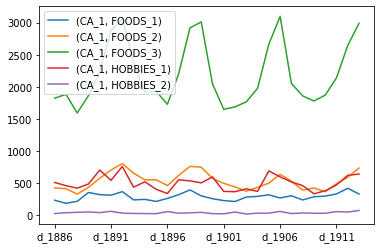

In [5]:
df = ref.sales_true_quantiles.loc[(ref.sales_true_quantiles.level==9) & (ref.sales_true_quantiles['quantile']==0.5)]
df = df[select_day_nums(df, as_int=False)]
df.head().T.plot()

## Data preparation (or read saved result)
From `lightgbm-poisson-w-scaled-pinball-loss.ipynb`.  

+ swapperooni with normalised sales. 

Note: categorical features are converted on-the-fly to reduce memory usage. 

In [7]:
converted_sales = pd.read_csv(data_dir + 'prep/converted_sales_level_9.csv', index_col=0)
converted_sales.head()

,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,...,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2
d_1,0.039918,0.157390,0.332159,0.128703,0.002232,0.092110,0.055111,0.068430,0.096287,0.303981,...,0.000661,0.103576,0.033436,0.025095,0.129525,0.313295,0.041697,0.001678,0.132314,0.045657
d_2,0.038171,0.152953,0.321907,0.119196,0.000717,0.089303,0.051761,0.068767,0.103100,0.248203,...,0.000463,0.078636,0.032071,0.022783,0.129969,0.325592,0.055705,0.001068,0.122572,0.060156
d_3,0.028762,0.092472,0.204744,0.099696,0.000478,0.071187,0.034711,0.040114,0.062677,0.176213,...,0.001190,0.073354,0.023542,0.020967,0.127748,0.251538,0.037137,0.001525,0.095157,0.032700
d_4,0.023521,0.111153,0.235353,0.093358,0.000717,0.070932,0.037451,0.040451,0.079028,0.217322,...,0.000992,0.089492,0.027295,0.016179,0.118416,0.268480,0.029807,0.000839,0.074087,0.028998
d_5,0.024462,0.082665,0.219096,0.064108,0.000399,0.049755,0.041105,0.037080,0.046327,0.184512,...,0.000066,0.034623,0.010918,0.014363,0.075538,0.194972,0.011402,0.000305,0.034211,0.016350


#### Check normalised sales

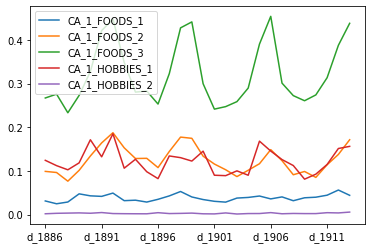

In [8]:
select_dates(converted_sales.T, day_end=1913, num_days=28).head().T.plot()

In [9]:
df1 = df.head().T
df2 = select_dates(converted_sales.T, day_end=1913, num_days=28).head().T
df1.columns = df2.columns

In [10]:
df1/df2

,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2
d_1886,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1887,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1888,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1889,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1890,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1891,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1892,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1893,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1894,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664
d_1895,7440.26172,4282.366797,6828.049503,4102.475899,12546.154664


In [11]:
norm = pd.read_csv(data_dir + 'prep/norm_level_9.csv', index_col='id')
norm.head()

,norm
id,
CA_1_FOODS_1,7440.261720
CA_1_FOODS_2,4282.366797
CA_1_FOODS_3,6828.049503
CA_1_HOBBIES_1,4102.475899
CA_1_HOBBIES_2,12546.154664


### Data pipeline with normalised sales

In [12]:
converted_sales = reduce_mem_usage(converted_sales.T)
converted_sales.head()

Mem. usage decreased to  0.26 Mb (74.8% reduction)


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,0.023651,...,0.039368,0.042603,0.036011,0.040588,0.031860,0.038574,0.039917,0.044495,0.056305,0.044220
CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,0.130493,...,0.101562,0.116516,0.148804,0.123535,0.091309,0.098755,0.085205,0.114197,0.137817,0.171387
CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,0.250488,...,0.289795,0.390381,0.453857,0.301025,0.272461,0.260742,0.273926,0.313477,0.387451,0.437988
CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,0.091431,...,0.090210,0.168213,0.145508,0.125977,0.112366,0.081177,0.092651,0.114807,0.151367,0.156250
CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,0.000717,...,0.002470,0.002550,0.004623,0.001993,0.002710,0.002392,0.002392,0.004463,0.003906,0.005817


In [13]:
calendar, sell_prices, sales_train_val, submission = read_data() # with memory reduction

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [14]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [15]:
converted_sales.index.name = 'id'
converted_sales = converted_sales.reset_index()
converted_sales.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,...,0.039368,0.042603,0.036011,0.040588,0.031860,0.038574,0.039917,0.044495,0.056305,0.044220
1,CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,...,0.101562,0.116516,0.148804,0.123535,0.091309,0.098755,0.085205,0.114197,0.137817,0.171387
2,CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,...,0.289795,0.390381,0.453857,0.301025,0.272461,0.260742,0.273926,0.313477,0.387451,0.437988
3,CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,...,0.090210,0.168213,0.145508,0.125977,0.112366,0.081177,0.092651,0.114807,0.151367,0.156250
4,CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,...,0.002470,0.002550,0.004623,0.001993,0.002710,0.002392,0.002392,0.004463,0.003906,0.005817


In [16]:
for i, col in enumerate(['state_id', 'store_num', 'cat_id', 'cat_num']):
    converted_sales[col] = converted_sales.apply(lambda row: row.id.split('_')[i], axis=1)
converted_sales.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,state_id,store_num,cat_id,cat_num
0,CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,...,0.031860,0.038574,0.039917,0.044495,0.056305,0.044220,CA,1,FOODS,1
1,CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,...,0.091309,0.098755,0.085205,0.114197,0.137817,0.171387,CA,1,FOODS,2
2,CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,...,0.272461,0.260742,0.273926,0.313477,0.387451,0.437988,CA,1,FOODS,3
3,CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,...,0.112366,0.081177,0.092651,0.114807,0.151367,0.156250,CA,1,HOBBIES,1
4,CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,...,0.002710,0.002392,0.002392,0.004463,0.003906,0.005817,CA,1,HOBBIES,2


In [17]:
converted_sales['store_id'] = converted_sales['state_id'] + '_' + converted_sales['store_num'].astype(str)
converted_sales['dept_id'] = converted_sales['cat_id'] + '_' + converted_sales['cat_num'].astype(str)
converted_sales.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1910,d_1911,d_1912,d_1913,state_id,store_num,cat_id,cat_num,store_id,dept_id
0,CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,...,0.039917,0.044495,0.056305,0.044220,CA,1,FOODS,1,CA_1,FOODS_1
1,CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,...,0.085205,0.114197,0.137817,0.171387,CA,1,FOODS,2,CA_1,FOODS_2
2,CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,...,0.273926,0.313477,0.387451,0.437988,CA,1,FOODS,3,CA_1,FOODS_3
3,CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,...,0.092651,0.114807,0.151367,0.156250,CA,1,HOBBIES,1,CA_1,HOBBIES_1
4,CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,...,0.002392,0.004463,0.003906,0.005817,CA,1,HOBBIES,2,CA_1,HOBBIES_2


In [18]:
converted_sales.drop(columns=['store_num', 'cat_num'], inplace=True)

### Replace demand with normalised sales

In [19]:
converted_sales

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,state_id,cat_id,store_id,dept_id
0,CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,...,0.031860,0.038574,0.039917,0.044495,0.056305,0.044220,CA,FOODS,CA_1,FOODS_1
1,CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,...,0.091309,0.098755,0.085205,0.114197,0.137817,0.171387,CA,FOODS,CA_1,FOODS_2
2,CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,...,0.272461,0.260742,0.273926,0.313477,0.387451,0.437988,CA,FOODS,CA_1,FOODS_3
3,CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,...,0.112366,0.081177,0.092651,0.114807,0.151367,0.156250,CA,HOBBIES,CA_1,HOBBIES_1
4,CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,...,0.002710,0.002392,0.002392,0.004463,0.003906,0.005817,CA,HOBBIES,CA_1,HOBBIES_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,WI_3_FOODS_3,0.313232,0.325684,0.251465,0.268555,0.194946,0.377197,0.372559,0.517090,0.434326,...,0.234375,0.215698,0.228149,0.259277,0.329346,0.305176,WI,FOODS,WI_3,FOODS_3
66,WI_3_HOBBIES_1,0.041687,0.055695,0.037140,0.029800,0.011398,0.046417,0.058136,0.065002,0.035187,...,0.040558,0.032898,0.029648,0.042999,0.062042,0.037476,WI,HOBBIES,WI_3,HOBBIES_1
67,WI_3_HOBBIES_2,0.001678,0.001068,0.001525,0.000839,0.000305,0.000610,0.000229,0.000992,0.000305,...,0.002060,0.003202,0.001601,0.002439,0.002439,0.001601,WI,HOBBIES,WI_3,HOBBIES_2
68,WI_3_HOUSEHOLD_1,0.132324,0.122559,0.095154,0.074097,0.034210,0.088806,0.111450,0.146606,0.094727,...,0.126465,0.121216,0.129761,0.158813,0.181519,0.173584,WI,HOUSEHOLD,WI_3,HOUSEHOLD_1


In [20]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [21]:
sales_train_val = converted_sales.copy()

### Continue pipeline

In [22]:
NUM_ITEMS = sales_train_val.shape[0]  # 70
DAYS_PRED = submission.shape[1] - 1   # 28
print(NUM_ITEMS, DAYS_PRED)

70 28


In [23]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to  0.26 Mb (0.7% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [24]:
sales_train_val

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,state_id,cat_id,store_id,dept_id
0,CA_1_FOODS_1,0.039917,0.038177,0.028763,0.023514,0.024460,0.025665,0.030106,0.035339,0.032928,...,0.031860,0.038574,0.039917,0.044495,0.056305,0.044220,0,0,0,0
1,CA_1_FOODS_2,0.157349,0.152954,0.092468,0.111145,0.082642,0.113464,0.129395,0.174438,0.135620,...,0.091309,0.098755,0.085205,0.114197,0.137817,0.171387,0,0,0,1
2,CA_1_FOODS_3,0.332275,0.322021,0.204712,0.235352,0.219116,0.253418,0.280518,0.432373,0.379639,...,0.272461,0.260742,0.273926,0.313477,0.387451,0.437988,0,0,0,2
3,CA_1_HOBBIES_1,0.128662,0.119202,0.099670,0.093384,0.064087,0.110413,0.082642,0.182861,0.103577,...,0.112366,0.081177,0.092651,0.114807,0.151367,0.156250,0,1,0,3
4,CA_1_HOBBIES_2,0.002232,0.000717,0.000478,0.000717,0.000399,0.001116,0.000558,0.001514,0.000558,...,0.002710,0.002392,0.002392,0.004463,0.003906,0.005817,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,WI_3_FOODS_3,0.313232,0.325684,0.251465,0.268555,0.194946,0.377197,0.372559,0.517090,0.434326,...,0.234375,0.215698,0.228149,0.259277,0.329346,0.305176,2,0,9,2
66,WI_3_HOBBIES_1,0.041687,0.055695,0.037140,0.029800,0.011398,0.046417,0.058136,0.065002,0.035187,...,0.040558,0.032898,0.029648,0.042999,0.062042,0.037476,2,1,9,3
67,WI_3_HOBBIES_2,0.001678,0.001068,0.001525,0.000839,0.000305,0.000610,0.000229,0.000992,0.000305,...,0.002060,0.003202,0.001601,0.002439,0.002439,0.001601,2,1,9,4
68,WI_3_HOUSEHOLD_1,0.132324,0.122559,0.095154,0.074097,0.034210,0.088806,0.111450,0.146606,0.094727,...,0.126465,0.121216,0.129761,0.158813,0.181519,0.173584,2,2,9,5


In [25]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))

Melted sales train validation has 133910 rows and 7 columns


In [26]:
sales_train_val.head()

,id,dept_id,cat_id,store_id,state_id,day,demand
0,CA_1_FOODS_1,0,0,0,0,d_1,0.039917
1,CA_1_FOODS_2,1,0,0,0,d_1,0.157349
2,CA_1_FOODS_3,2,0,0,0,d_1,0.332275
3,CA_1_HOBBIES_1,3,1,0,0,d_1,0.128662
4,CA_1_HOBBIES_2,4,1,0,0,d_1,0.002232


In [27]:
data = sales_train_val

In [29]:
data[data.day=='d_1886']

,id,dept_id,cat_id,store_id,state_id,day,demand
131950,CA_1_FOODS_1,0,0,0,0,d_1886,0.031311
131951,CA_1_FOODS_2,1,0,0,0,d_1886,0.098999
131952,CA_1_FOODS_3,2,0,0,0,d_1886,0.267090
131953,CA_1_HOBBIES_1,3,1,0,0,d_1886,0.124329
131954,CA_1_HOBBIES_2,4,1,0,0,d_1886,0.001993
...,...,...,...,...,...,...,...
132015,WI_3_FOODS_3,2,0,9,2,d_1886,0.205444
132016,WI_3_HOBBIES_1,3,1,9,2,d_1886,0.028183
132017,WI_3_HOBBIES_2,4,1,9,2,d_1886,0.002974
132018,WI_3_HOUSEHOLD_1,5,2,9,2,d_1886,0.128296


In [32]:
print("{:.2f} MB".format(data.memory_usage().sum() / 1024**2))

2.81 MB


### Save prepared dataset
Pickle chosen for its speed. See: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
Feather and parquet both require additional libraries (pyarrow). 

In [56]:
fn = os.environ['DATA_DIR'] + 'prep/level_9_simple_fe_{}_{}_normalised_demand.pickle'.format(
    data.date.min().date().strftime("%Y_%m_%d"), data.date.max().date().strftime("%Y_%m_%d")
)
print("Saving to file..")
data.to_pickle(fn)
print("Finished.")

Saving to file..
Finished.


### Read prepared dataset

In [6]:
fn = data_dir + 'prep/level_9_simple_fe_2011_04_27_2016_04_24_normalised_demand.pickle'
data = pd.read_pickle(fn)

In [7]:
features = [
#     "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
#     "sell_price",
#     "price_change_t1",
#     "price_change_t365",
#     "rolling_price_std_t7",
#     "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

In [8]:
data.head()[features]

,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,...,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,...,17,27,2,0,0,0,0,0,0,0
1,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,...,17,27,2,0,0,0,0,0,0,0
2,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,...,17,27,2,0,0,0,0,0,0,0
3,3.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,...,17,27,2,0,0,0,0,0,0,0
4,4.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,...,17,27,2,0,0,0,0,0,0,0


In [9]:
categorical_features = [
#     "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
]

In [10]:
for col in categorical_features:
    if col in data.columns:
        data[col] = data[col].astype('category')

## BatchCreator

In [11]:
class BatchCreator(Sequence):
    """Batch creator for M5 Uncertainty challenge.
    - batch_size: number of samples per batch. Note: if ensure_all_samples is True,
                  the final batch size may be smaller.
    - shuffle: whether to shuffle the samples.
    - ensure_all_samples: whether to ensure all samples are yielded. If False (default),
                          the batch size is always constant.
    - inp_shape: input shape of how a single sample enters the neural network. This is without the batch size.
    - categorical_features: which columns to convert to one-hot encoding
    """

    def __init__(self, df, features, labels, batch_size=128, shuffle=True, ensure_all_samples=False,
                 inp_shape=(3244,), out_shape=(9,), categorical_features=None):
        """Initialization"""
        # Save settings
        self.df = df
        self.list_IDs = self.df.index
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        self.inp_shape = inp_shape
        self.out_shape = out_shape
        self.categorical_features = [c for c in categorical_features
                                     if c in features]
        
        # initialize indices
        self.indexes = None
        self.on_epoch_end()

        # calculate properties
        self.n = self.df.index.size

    def __len__(self):
        """Denotes the number of batches per epoch"""
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size))
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = self.list_IDs[indexes]

        # Generate data
        x_batch, y_batch = self.__data_generation(list_IDs_temp)

        return x_batch, y_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        
        # fill labels
        demand = self.df.loc[list_IDs_temp, 'demand'].values.astype(np.float32)
        y_batch = {'q%d'%d: demand for d in range(9)}

        # fill features
        x_batch = self.df.loc[list_IDs_temp, self.features]
        x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)#, dummy_na=True)
        x_batch = x_batch.replace(np.nan, 0)
        x_batch = x_batch.values

        return x_batch, y_batch

    def flow(self, epochs=None):
        """returns a generator that will yield batches infinitely"""
        epochs_done = 0
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y

            # track nr. of epochs
            epochs_done += 1
            if epochs is not None and epochs_done == epochs:
                break # stop yielding new elements

            # do on epoch end
            self.on_epoch_end()

In [12]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [13]:
labels = ['demand']
batch_size = 64#25000
train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=categorical_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=categorical_features, batch_size=batch_size)

## Initialize pinball loss

In [14]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [15]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

## Logger

In [16]:
class Logger(Callback):
    def __init__(self, val_batch_creator, model_name="model", update_plot=True):
        super().__init__()
        self.val_batch_creator = val_batch_creator
        self.update_plot = update_plot

        # validation metrics
        self.val_x = []
        self.val_spl = []
        # save best model properties
        self.best_spl = np.inf
        self.best_model = None
        self.best_epoch = 0
        self.model_name = model_name
        
        # initialize metrics
        self.train_metrics = {}
        self.metric_names = ['loss']
        self.metric_names.extend(['q{}_loss'.format(d) for d in range(9)])
        for m in self.metric_names:
            self.train_metrics[m] = []
        print("Tracking {}".format(self.metric_names))
        
        self.val_metrics = {}
        self.val_metric_names = ['val_{}'.format(m) for m in self.metric_names]
        for m in self.val_metric_names:
            self.val_metrics[m] = []
        print("Tracking {}".format(self.val_metric_names))

    def on_batch_end(self, batch, logs={}):
        # log training metrics
        for m in self.metric_names:
            if m in logs.keys():
                self.train_metrics[m].append(logs.get(m))

    def on_epoch_end(self, batch, logs={}):
        num_train_steps = len(self.train_metrics['loss'])
        timestamp = time.strftime('%Y-%m-%d_%H%M', time.localtime())
        self.model.save(model_dir + '{}_{}_{}_steps.h5'.format(
            self.model_name, timestamp, num_train_steps))
        
        # calculate normalised validation PL
        if 'val_loss' in logs.keys():
            for m in self.val_metric_names:
                self.val_metrics[m].append(logs.get(m))
        else:
            # evaluate validation set
            val_losses = self.model.evaluate(self.val_batch_creator.flow(), 
                                             steps=val_batch_creator.__len__())
            for i, m in self.val_metric_names:
                self.val_metrics[m] = val_losses[i]
        
        self.val_x.append(num_train_steps)
        spl = self.val_metrics['val_loss'][-1]

        if spl < self.best_spl:
            self.best_spl = spl
            self.best_model = self.model.get_weights()
            self.best_epoch = len(self.val_spl)
        if self.update_plot:
            self.plot()

    def validate(self):
        pass
    
    # first try: 7.687106850995075/0.0018890968224565899
    def plot(self, experimental_pinball_boost=3.671080060420607/0.03552745282649994, clear=True):
        if clear:
            clear_output()

        f, axes2d = plt.subplots(2, 2, figsize=(18, 12))

        # plot losses
        losses = self.train_metrics['loss']
        val_losses = self.val_metrics['val_loss']
        
        for i, axes in enumerate(axes2d):
            if i == 1:
                # experimental: convert normalised PL -> WSPL
                losses = np.array(losses) * experimental_pinball_boost
                val_losses = np.array(val_losses) * experimental_pinball_boost
            
            ax = axes[0]
            ax.plot(range(1, 1+len(losses)), losses, label='Train')
            if len(val_losses):
                ax.plot(self.val_x, val_losses, '.-', label='Validation')
            ax.set_xlabel("Step")
            ax.set_ylabel(r"normalised PL")
            ax.set_title("Loss")
            ax.set_ylim(0)

            # plot final losses
            ax = axes[1]
            N = len(losses)
            n = min(501, max(100, N-100))
            ax.plot(range(1+N-n, 1+N), losses[-n:], label='Train')
            if len(val_losses):
                indexer = [x > (N-n) for x in self.val_x]
                ax.plot(np.array(self.val_x)[indexer], np.array(val_losses)[indexer], '.-', label='Validation')
            ax.set_xlabel("Step")
            ax.set_ylabel(r"normalised PL")
            ax.set_title("Loss final {} steps".format(n))
            ax.set_ylim(0)

            for ax in axes:
                ax.legend()

        plt.show()

## Build model

In [17]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(64, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    
    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1, activation="relu")(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [18]:
def get_dense_model(inp_shape):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(64, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)
    out_q1 = Dense(1, name="q1")(x)
    out_q2 = Dense(1, name="q2")(x)
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)
    
    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

### Train dense model

In [19]:
logger = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


In [20]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_dense_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12608       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

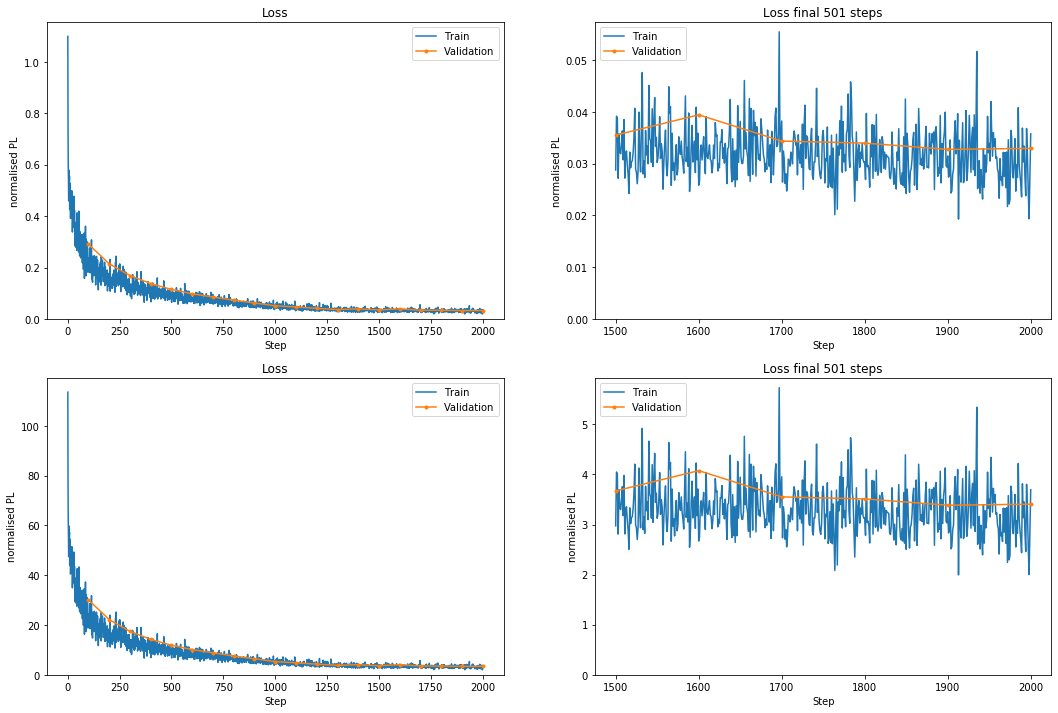

100/100 [==============================] - 4s 42ms/step - loss: 0.0307 - q0_loss: 2.8364e-04 - q1_loss: 9.8104e-04 - q2_loss: 0.0039 - q3_loss: 0.0051 - q4_loss: 0.0066 - q5_loss: 0.0057 - q6_loss: 0.0048 - q7_loss: 0.0014 - q8_loss: 0.0019 - val_loss: 0.0330 - val_q0_loss: 2.6020e-04 - val_q1_loss: 0.0010 - val_q2_loss: 0.0043 - val_q3_loss: 0.0056 - val_q4_loss: 0.0072 - val_q5_loss: 0.0063 - val_q6_loss: 0.0052 - val_q7_loss: 0.0014 - val_q8_loss: 0.0017


In [21]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

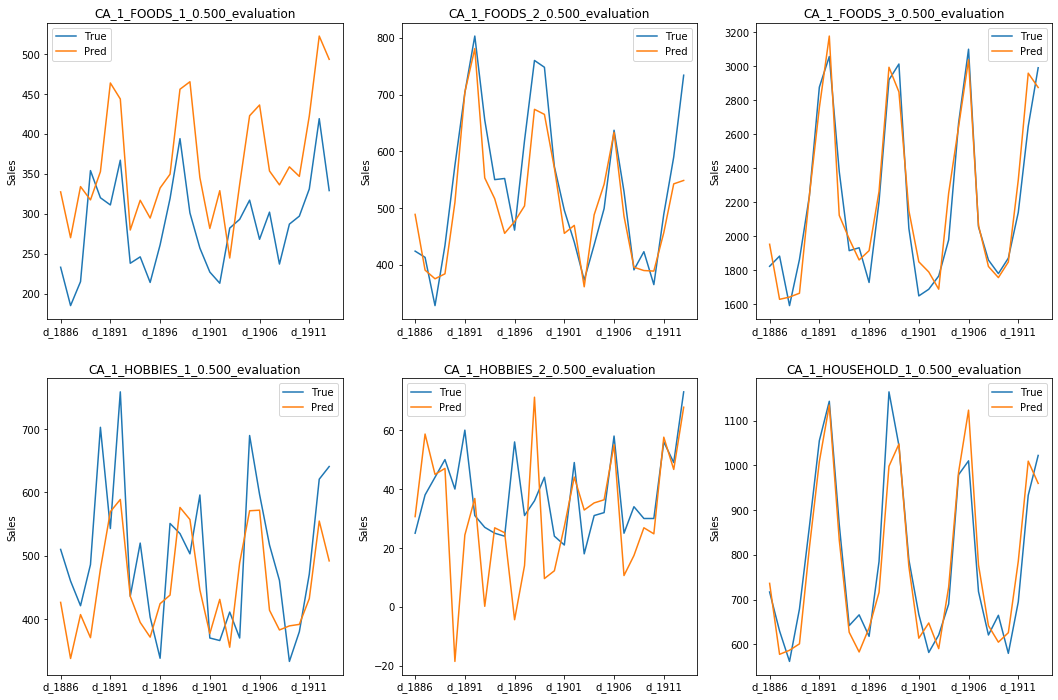

In [23]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

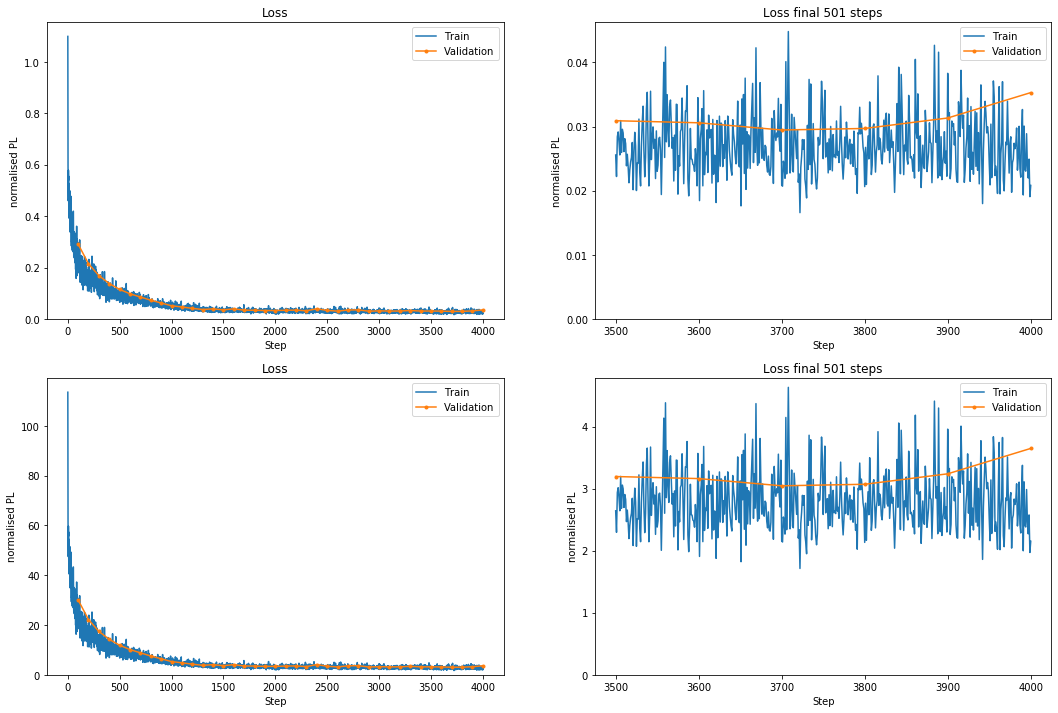

100/100 [==============================] - 4s 40ms/step - loss: 0.0269 - q0_loss: 2.5109e-04 - q1_loss: 8.9062e-04 - q2_loss: 0.0037 - q3_loss: 0.0048 - q4_loss: 0.0061 - q5_loss: 0.0052 - q6_loss: 0.0043 - q7_loss: 0.0013 - q8_loss: 5.0123e-04 - val_loss: 0.0353 - val_q0_loss: 2.5304e-04 - val_q1_loss: 0.0011 - val_q2_loss: 0.0047 - val_q3_loss: 0.0068 - val_q4_loss: 0.0082 - val_q5_loss: 0.0066 - val_q6_loss: 0.0057 - val_q7_loss: 0.0014 - val_q8_loss: 4.8658e-04


In [24]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

{9: 0.1778154982921681, 'WSPL': 0.1778154982921681}


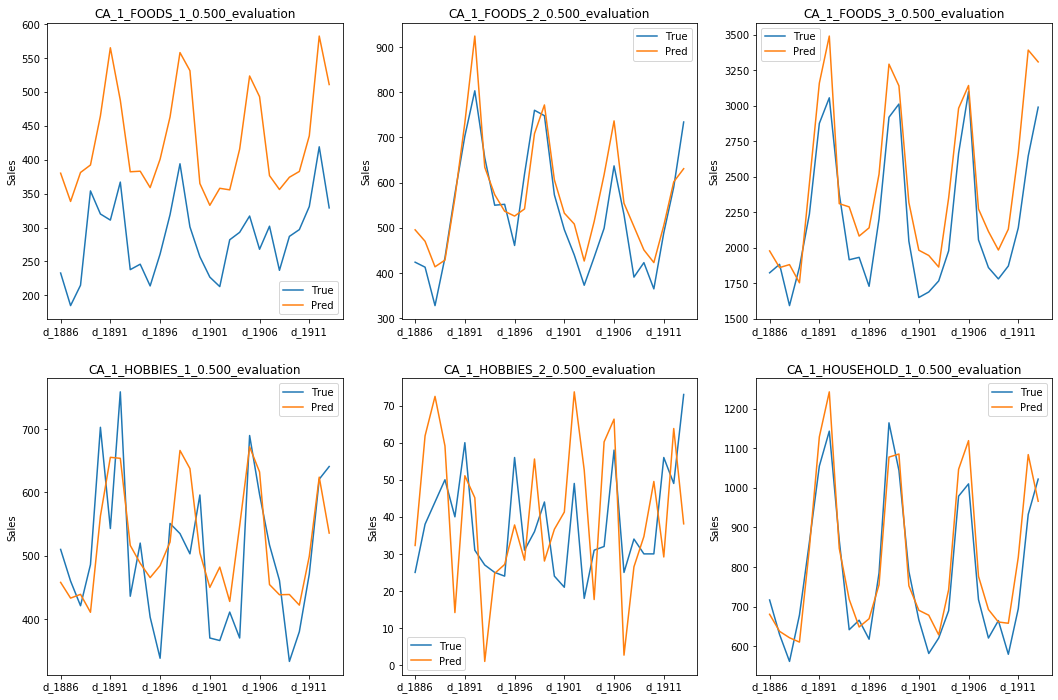

In [26]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

### Load best trained model (lowest validation loss)

In [27]:
model.set_weights(logger.best_model)

{9: 0.14683239329426753, 'WSPL': 0.14683239329426753}


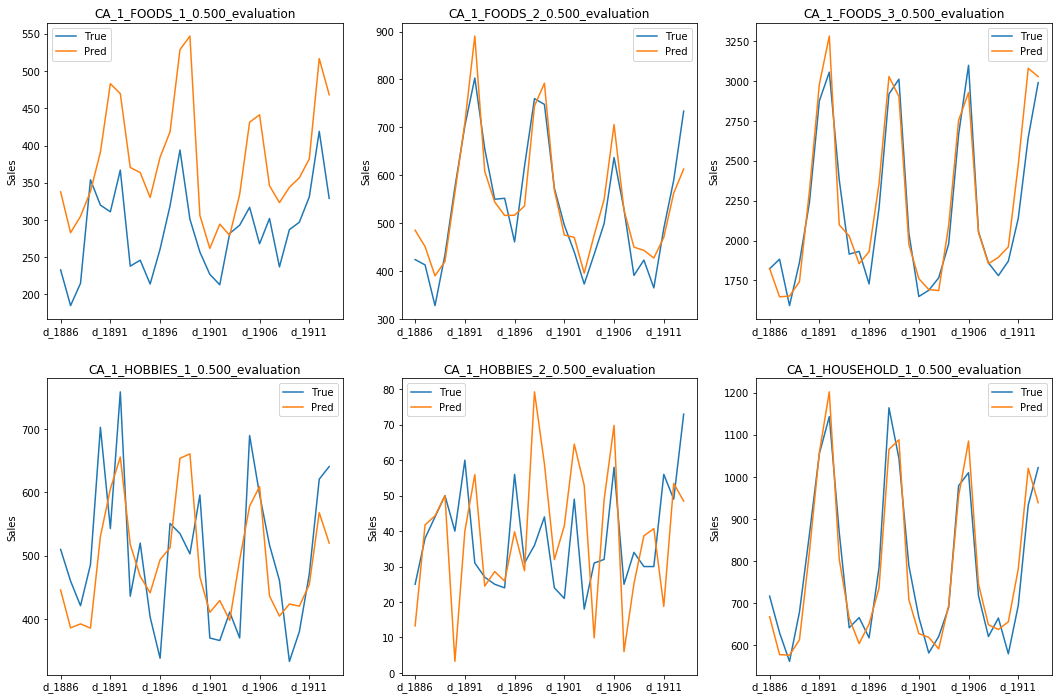

In [28]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

### Increase network size

In [29]:
logger2 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


In [30]:
def get_dense_model(inp_shape):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)  # represents "mu, sigma"
    
    out_q0 = Dense(1, name="q0")(x)
    out_q1 = Dense(1, name="q1")(x)
    out_q2 = Dense(1, name="q2")(x)
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)
    
    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [31]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_dense_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          25216       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
______________________________________________________________________________________________

### Train dense model

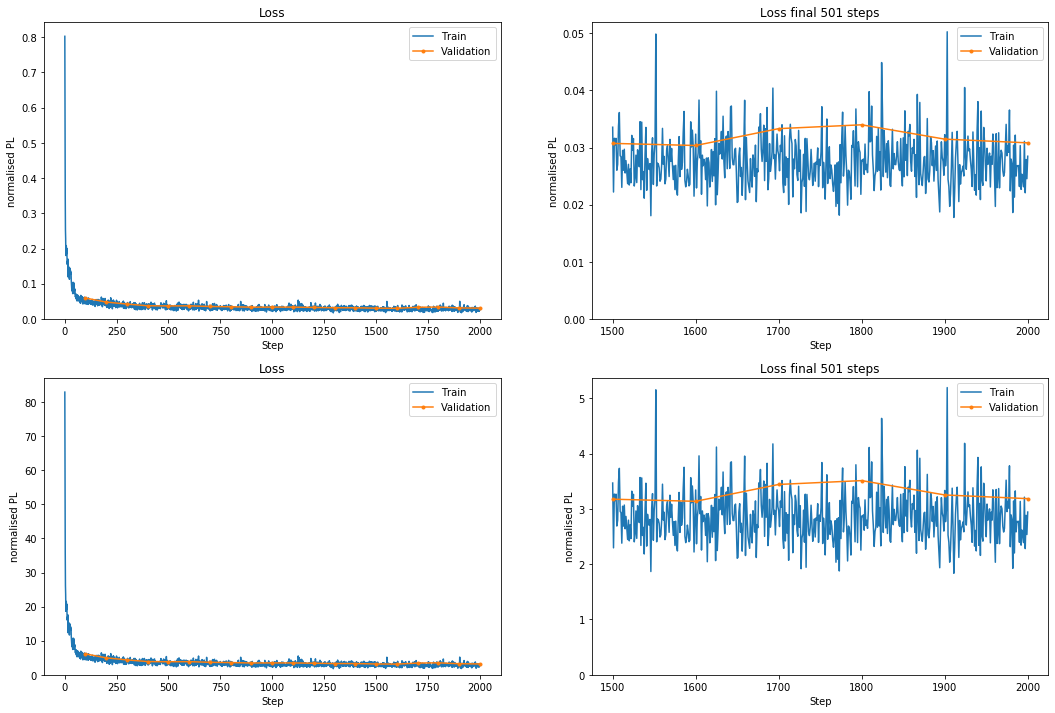

100/100 [==============================] - 4s 42ms/step - loss: 0.0273 - q0_loss: 2.3206e-04 - q1_loss: 8.8119e-04 - q2_loss: 0.0038 - q3_loss: 0.0048 - q4_loss: 0.0063 - q5_loss: 0.0053 - q6_loss: 0.0043 - q7_loss: 0.0012 - q8_loss: 3.9468e-04 - val_loss: 0.0308 - val_q0_loss: 2.4157e-04 - val_q1_loss: 9.2823e-04 - val_q2_loss: 0.0041 - val_q3_loss: 0.0054 - val_q4_loss: 0.0073 - val_q5_loss: 0.0061 - val_q6_loss: 0.0050 - val_q7_loss: 0.0015 - val_q8_loss: 3.9385e-04


In [33]:
# NOTE: Setting steps/epoch to 100 to evaluate more often
# note: full evaluation takes about a minute

history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger2])

{9: 0.15453523265916272, 'WSPL': 0.15453523265916272}


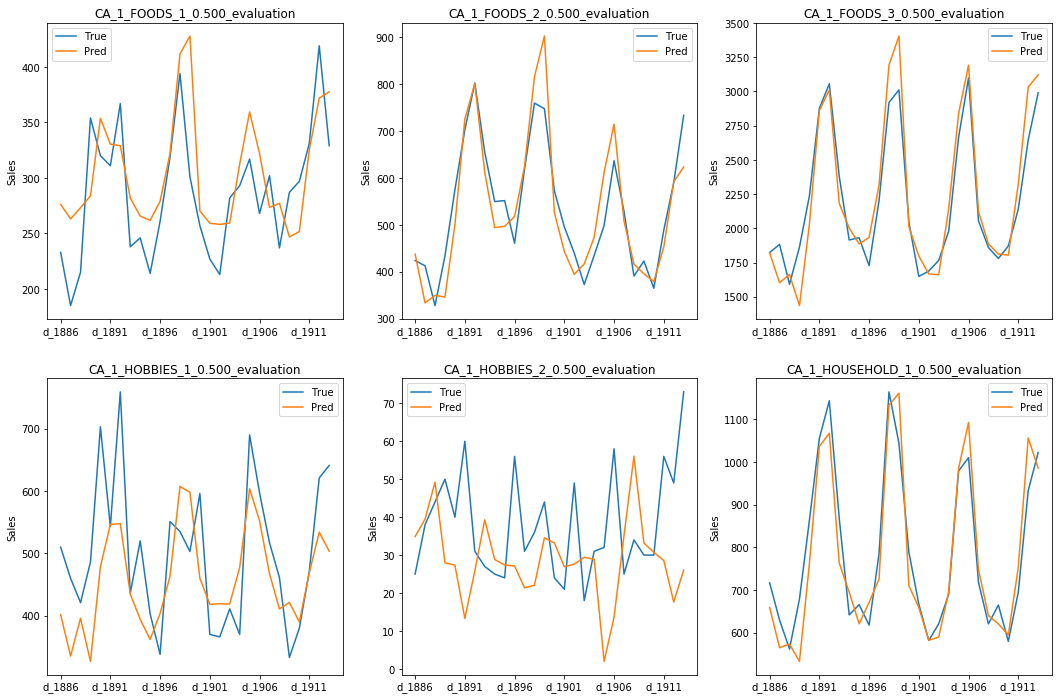

In [35]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

### Train dist model

In [43]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_dist_model(inp_shape=x[0].shape, sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12608       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [44]:
logger3 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


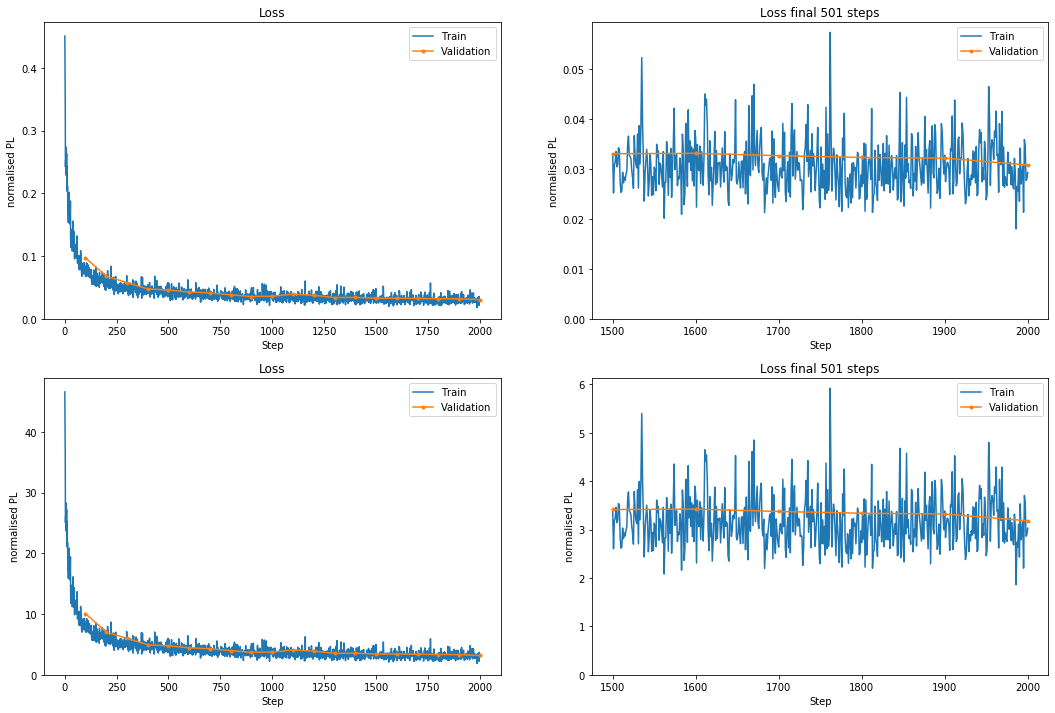

100/100 [==============================] - 4s 43ms/step - loss: 0.0308 - q0_loss: 2.7323e-04 - q1_loss: 0.0010 - q2_loss: 0.0042 - q3_loss: 0.0054 - q4_loss: 0.0070 - q5_loss: 0.0060 - q6_loss: 0.0049 - q7_loss: 0.0015 - q8_loss: 5.4032e-04 - val_loss: 0.0308 - val_q0_loss: 2.5148e-04 - val_q1_loss: 9.9330e-04 - val_q2_loss: 0.0040 - val_q3_loss: 0.0051 - val_q4_loss: 0.0069 - val_q5_loss: 0.0062 - val_q6_loss: 0.0052 - val_q7_loss: 0.0016 - val_q8_loss: 5.6238e-04


In [45]:
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger3])

{9: 0.15463808918031052, 'WSPL': 0.15463808918031052}


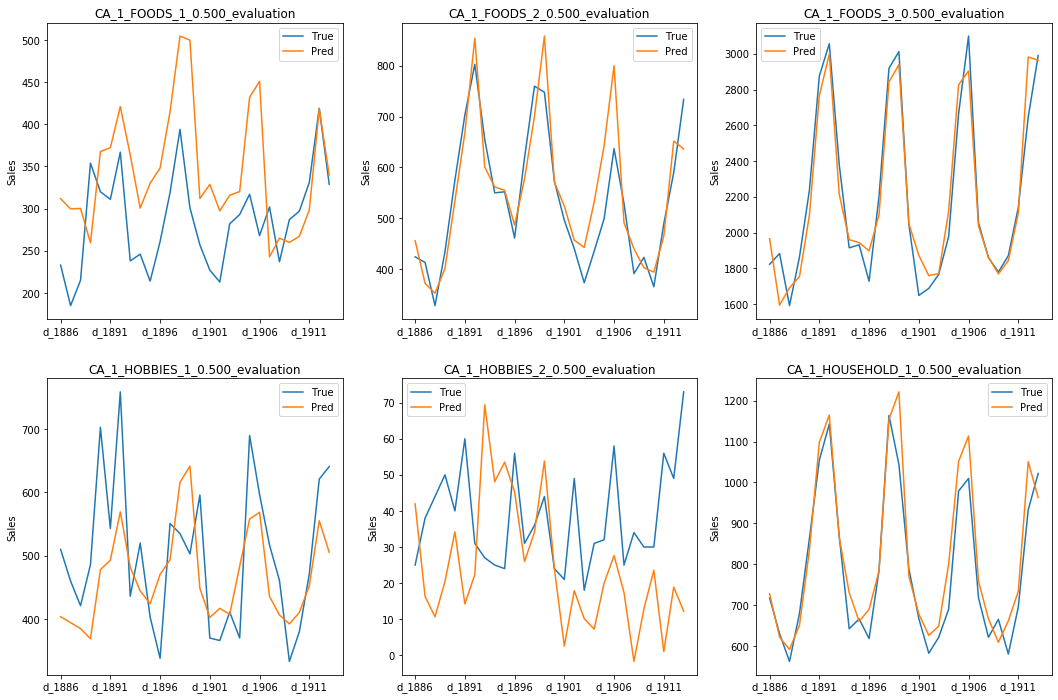

In [46]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

### LR scheduler

In [47]:
from tensorflow.keras.callbacks import LearningRateScheduler

def get_lr_test_scheduler(lr_start, lr_max, num):
    """LR test scheduler function. Ramps up linearly from lr_start to lr_max.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_test_scheduler(epoch, lr):
        lr_range = np.linspace(lr_start, lr_max, num=num)
        lr = lr_range[epoch]
        return lr
    return lr_test_scheduler

epochs = 20
lr_scheduler_func = get_lr_test_scheduler(lr_start=0.001, lr_max=0.001/10, num=epochs)
lr_callback = LearningRateScheduler(lr_scheduler_func, verbose=1)

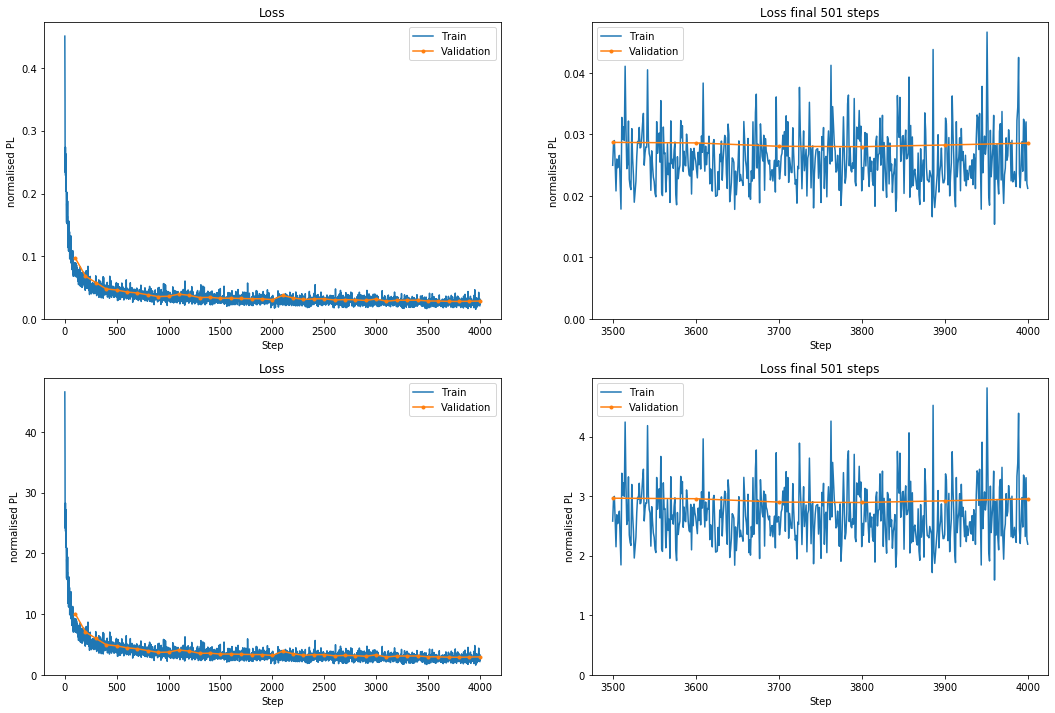

100/100 [==============================] - 4s 43ms/step - loss: 0.0265 - q0_loss: 2.1916e-04 - q1_loss: 8.5315e-04 - q2_loss: 0.0037 - q3_loss: 0.0047 - q4_loss: 0.0061 - q5_loss: 0.0051 - q6_loss: 0.0041 - q7_loss: 0.0012 - q8_loss: 4.3791e-04 - val_loss: 0.0286 - val_q0_loss: 2.3483e-04 - val_q1_loss: 8.9259e-04 - val_q2_loss: 0.0037 - val_q3_loss: 0.0049 - val_q4_loss: 0.0067 - val_q5_loss: 0.0058 - val_q6_loss: 0.0047 - val_q7_loss: 0.0012 - val_q8_loss: 3.5603e-04


In [48]:
history = model.fit(train_batch_creator.flow(), epochs=epochs,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger3, lr_callback])

{9: 0.14314085667112939, 'WSPL': 0.14314085667112939}


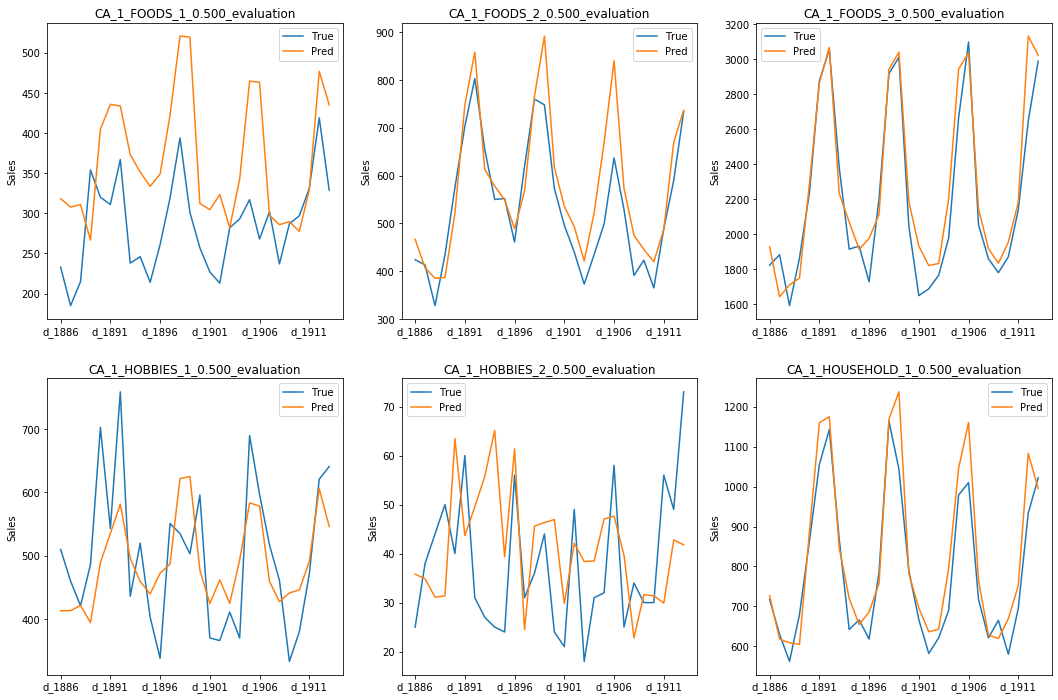

In [49]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

### Train large dist network

In [50]:
def get_large_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(512)(x)
    x = Dense(512)(x)
    x = Dense(512)(x)
    
    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [51]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_large_dist_model(inp_shape=x[0].shape, sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          100864      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
______________________________________________________________________________________________

In [52]:
logger4 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


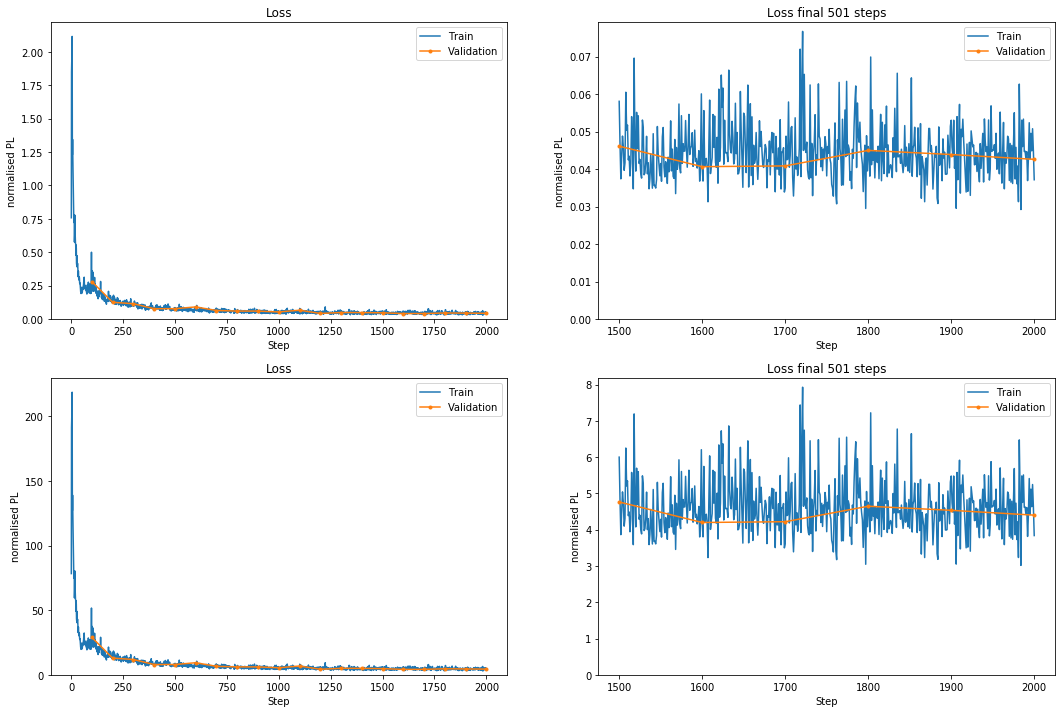

100/100 [==============================] - 5s 47ms/step - loss: 0.0442 - q0_loss: 4.0572e-04 - q1_loss: 0.0015 - q2_loss: 0.0057 - q3_loss: 0.0073 - q4_loss: 0.0097 - q5_loss: 0.0088 - q6_loss: 0.0073 - q7_loss: 0.0025 - q8_loss: 0.0011 - val_loss: 0.0426 - val_q0_loss: 4.1299e-04 - val_q1_loss: 0.0016 - val_q2_loss: 0.0064 - val_q3_loss: 0.0079 - val_q4_loss: 0.0093 - val_q5_loss: 0.0080 - val_q6_loss: 0.0065 - val_q7_loss: 0.0019 - val_q8_loss: 6.3749e-04


In [53]:
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger4])

{9: 0.2148140994822483, 'WSPL': 0.2148140994822483}


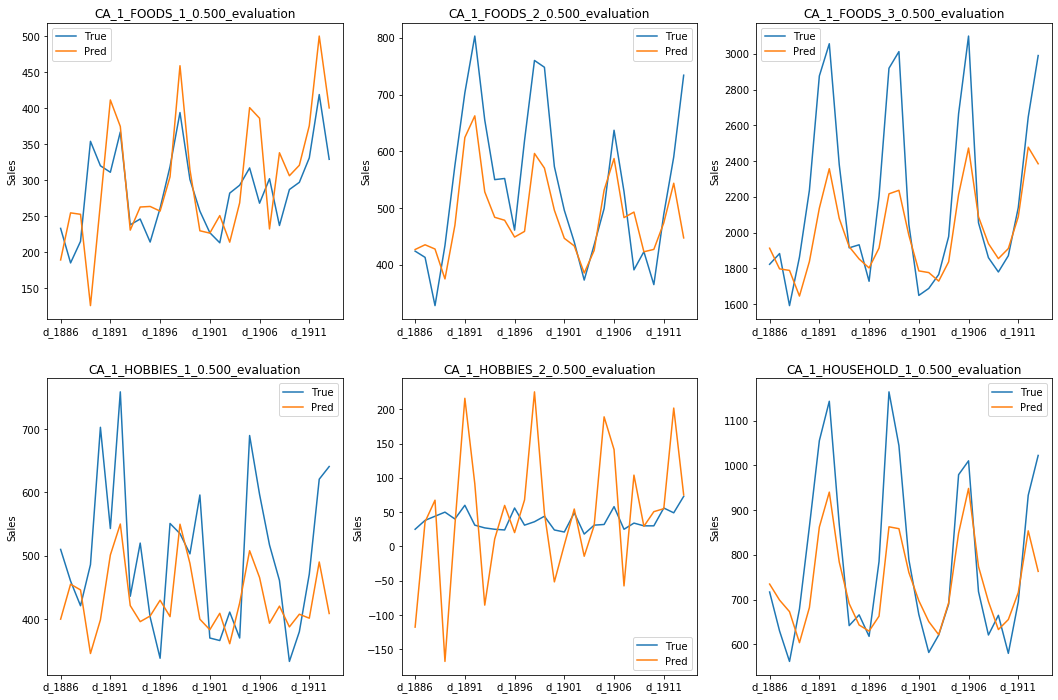

In [54]:
metrics, df = evaluate_model(model, ref, val_batch_creator)

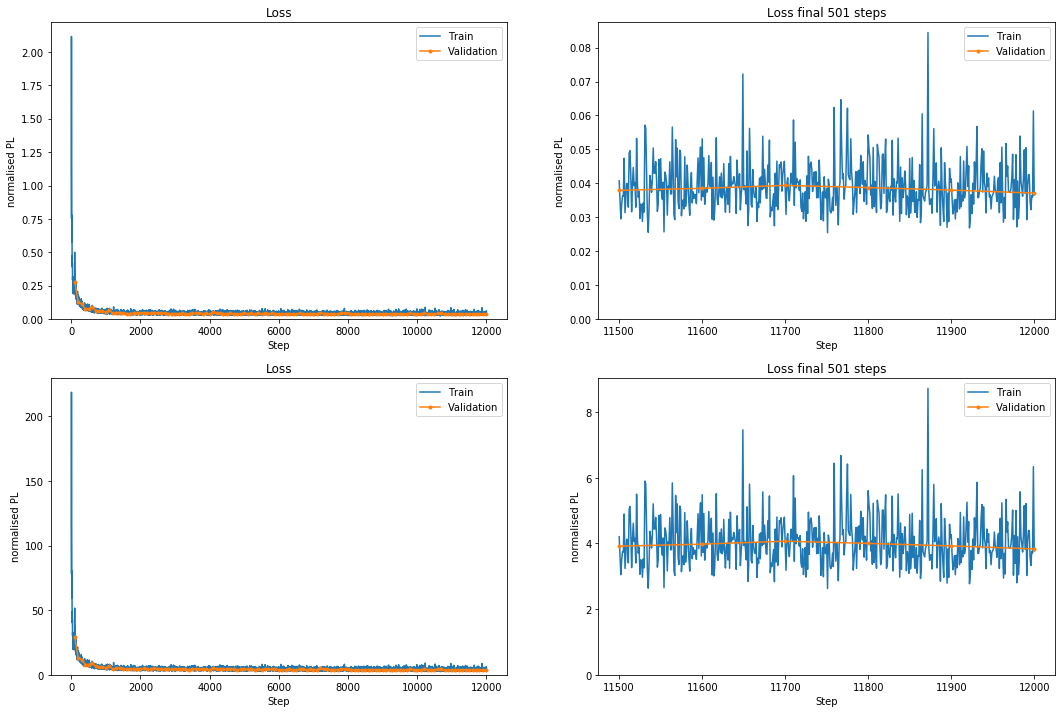

100/100 [==============================] - 5s 50ms/step - loss: 0.0389 - q0_loss: 3.6407e-04 - q1_loss: 0.0013 - q2_loss: 0.0052 - q3_loss: 0.0067 - q4_loss: 0.0088 - q5_loss: 0.0076 - q6_loss: 0.0063 - q7_loss: 0.0019 - q8_loss: 7.3406e-04 - val_loss: 0.0371 - val_q0_loss: 3.0742e-04 - val_q1_loss: 0.0012 - val_q2_loss: 0.0050 - val_q3_loss: 0.0064 - val_q4_loss: 0.0083 - val_q5_loss: 0.0073 - val_q6_loss: 0.0060 - val_q7_loss: 0.0019 - val_q8_loss: 7.4802e-04


In [55]:
history = model.fit(train_batch_creator.flow(), epochs=100,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger4])

{9: 0.18464417982918394, 'WSPL': 0.18464417982918394}


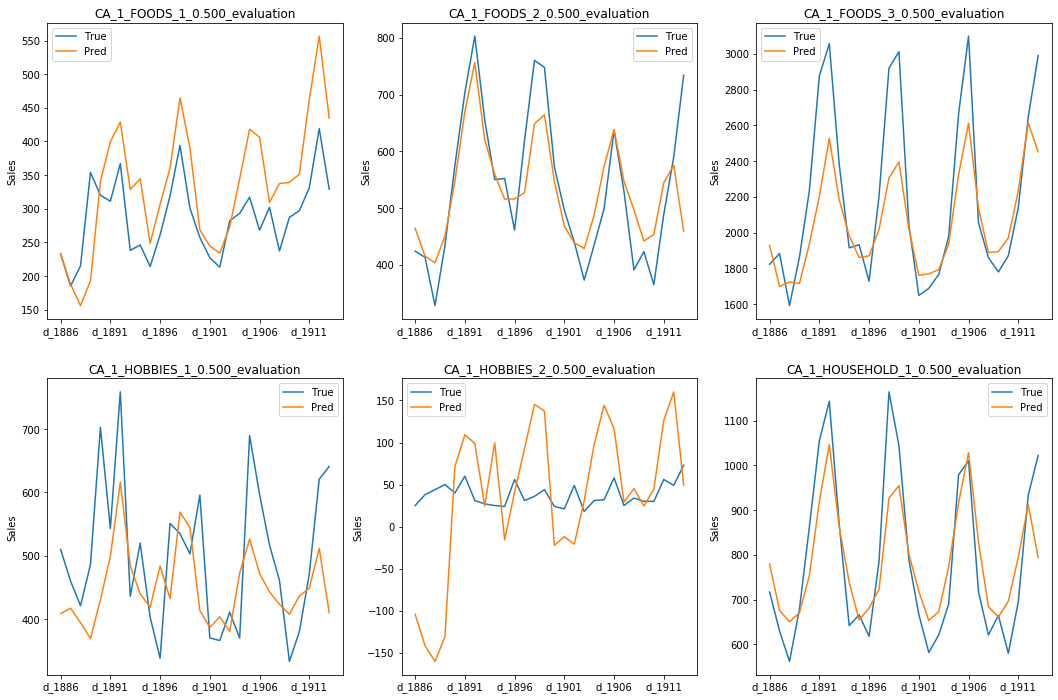

In [56]:
metrics, df = evaluate_model(model, ref, val_batch_creator)